# LP-based Shadow Ban Policy

## Clone and Install if Using Cluster

In [ ]:
!git clone https://github.com/zlisto/opinion_dynamics
import os
os.chdir("opinion_dynamics")

# Add opinoin_dynamics. when importing scripts, eg, from opinion_dynamics.scripts.opinion_data import * # load twitter network

# Import Packages

In [1]:
import numpy as np
from scipy.optimize import linprog # linear programming solver

import networkx as nx # create synthetic network

from scripts.opinion_data import * # load twitter network
from scripts.dynamics_simulator import * # class for shadow ban LP optimization and RK simulation
from scripts.opinion_visualization import * # plot simulation results

import matplotlib.pyplot as plt
import time # check running time
import psutil # check CPU and memory usage

# Initialization

## Load Network

For your network `G` you need the following node features
   1. `rates` = array of posting rate of each node
   2. `opinions0` = array of initial opinions of each node

### Load Synthetic Network

In [ ]:
n0 = 20
nc = int(n0/2)
sizes = [nc, nc]
p0, p1 = 8/n0, 1/n0
probs = [[p0, p1], [p1, p0]]
G = nx.DiGraph(nx.stochastic_block_model(sizes, probs, seed=0))

for i in range(nc):
    rate = 1
    opinion0 = i/(nc-1)/2 
    opinion1 = 1-i/(nc-1)/2 
    G.nodes[i]['opinion'] = opinion0
    G.nodes[i+nc]['opinion'] = opinion1
    G.nodes[i]['rate'] = 1
    G.nodes[i+nc]['rate'] = 1
fig = draw_network(G)

A = nx.adjacency_matrix(G)
A = A.tocoo()
assert n0 == A.shape[0]  #number of nodes in network should equal shape of A
rates = np.array([G.nodes[v]["rate"] for v in G.nodes()])  #posting rates of nodes
opinions0 = np.array([G.nodes[v]["opinion"] for v in G.nodes()])  #initial opinions of nodes

plt.hist(opinions0)
plt.show()

E0 = nx.incidence_matrix(G,oriented=True)
E0 = E0.tocoo()
ind = E0.data>0
E = coo_matrix((E0.data[ind], (E0.row[ind], E0.col[ind])), E0.shape)  #incidence matrix with only tail of edge


network_params = {'A':A, 'rates':rates, 'opinions0':opinions0, 'E':E}
network_params['data_name'] = 'synthetic'

network_params

### Load US Election Full Data

Mean rate 0.09730295339735406 tweets/day
CPU times: user 9.62 s, sys: 749 ms, total: 10.4 s
Wall time: 11.2 s


{'A': <77563x77563 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'E': <77563x5022773 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'rates': array([0.01923077, 0.04166667, 0.01282051, ..., 0.04487179, 0.00961538,
        1.31089744]),
 'opinions0': array([0.62639551, 0.33246811, 0.17944451, ..., 0.24893551, 0.39323948,
        0.23936598]),
 'data_name': 'US Election'}

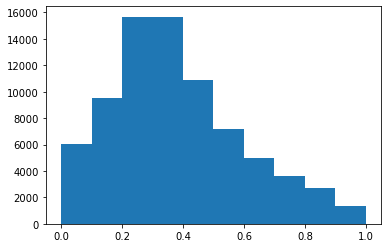

In [2]:
%%time
network_params = load_us_election()
network_params['data_name'] = 'US Election'

plt.hist(network_params['opinions0'])
print(f"Mean rate {network_params['rates'].mean()} tweets/day")
network_params

### Load Gilets Jaunes Full Data

In [ ]:
%%time
network_params = load_giletsjaunes()
network_params['data_name'] = 'Gilets Jaunes'

plt.hist(network_params['opinions0'])
print(f"Mean rate {network_params['rates'].mean()} tweets/day")
network_params

## Set Simulation and Optimization Parameters

In [18]:
#simulation parameters
tau = 0.1
omega = 0.1

#shift function f
def shift(x):
    x = np.clip(x, -1, 1)
    y = omega *x*np.exp(-np.abs(x/tau)**2/2)
    
    return(y)

#for dynamics_simulator.py
Tf = 60 #final time of simulator [days]
control_steps = Tf
sim_steps = 3

#optimization parameters 
smax = 0.5 #max strength of shadow banning at any time
OBJECTIVE = 'MEAN' #integral cost type
thres = 0.7 #used for EXTMIN and EXTMAX
assert OBJECTIVE in ['MEAN','VARMIN','VARMAX','EXTMIN','EXTMAX']

additional_params = {'tau': tau, 'omega': omega, 'shift': shift, 
                     'Tf': Tf, 'control_steps': control_steps, 'sim_steps': sim_steps, 
                     'OBJECTIVE': OBJECTIVE, 'smax': smax, 'thres': thres}

params = {**network_params, **additional_params}
nv = params['A'].shape[0]
ne = params['E'].shape[1]

params

{'A': <77563x77563 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'E': <77563x5022773 sparse matrix of type '<class 'numpy.float64'>'
 	with 5022773 stored elements in COOrdinate format>,
 'rates': array([0.01923077, 0.04166667, 0.01282051, ..., 0.04487179, 0.00961538,
        1.31089744]),
 'opinions0': array([0.62639551, 0.33246811, 0.17944451, ..., 0.24893551, 0.39323948,
        0.23936598]),
 'data_name': 'US Election',
 'tau': 0.1,
 'omega': 0.1,
 'shift': <function __main__.shift(x)>,
 'Tf': 60,
 'control_steps': 60,
 'sim_steps': 3,
 'OBJECTIVE': 'MEAN',
 'smax': 0.5,
 'thres': 0.7}

## Check Relaxation Time

You want the minimum relaxation time (which is greater than zero) to be greater than your simulation discretization time (which is one hour in our case).

1. US Election - relaxation time min = 7.3e-3  hours, 25% = 4.0  hours, 50% = 23.2 hours

2. Gilets Jaunes - relaxation time min = 5.1e-3 hours, 25% = 1.1 hours, 50% = 2.55 hours


In [4]:
relaxation_time_hrs = pd.Series(24/(params['omega']*params['rates']@params['A']))
relaxation_time_hrs[relaxation_time_hrs>0].describe()

<ipython-input-4-b08ab4ddde0e>:1: RuntimeWarning: divide by zero encountered in divide
  relaxation_time_hrs = pd.Series(24/(params['omega']*params['rates']@params['A']))


count    7.756300e+04
mean              inf
std               NaN
min      7.308674e-02
25%      3.897970e+01
50%      2.318266e+02
75%      7.488000e+03
max               inf
dtype: float64

# Optimize by LP and Simulate by RK

1. Optimize control by linear programming for `control_steps` control intervals
2. Solve state ivp by Runge-Kutta method for `sim_steps` within each control interval

Took 7.77 mins to simulate no ban
Took 13.32 mins to simulate ban EXTMAX smax = 0.0
Took 13.22 mins to simulate ban EXTMAX smax = 0.25
Took 13.57 mins to simulate ban EXTMAX smax = 0.5
Took 14.59 mins to simulate ban EXTMAX smax = 0.75
Took 12.88 mins to simulate ban EXTMAX smax = 1.0


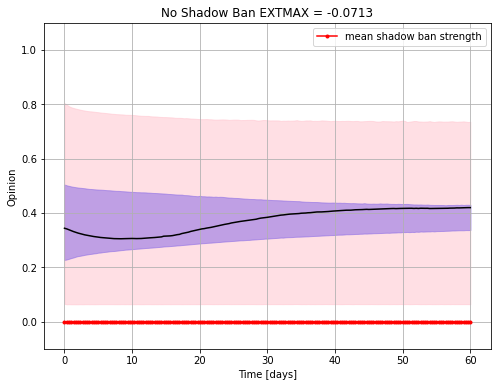

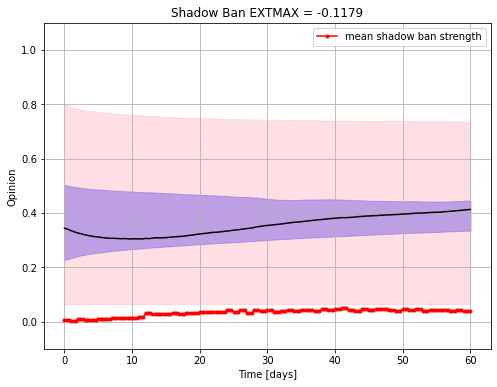

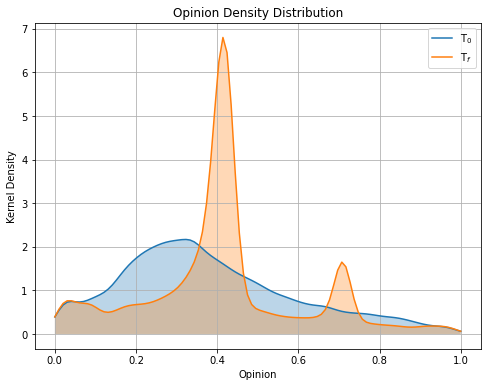

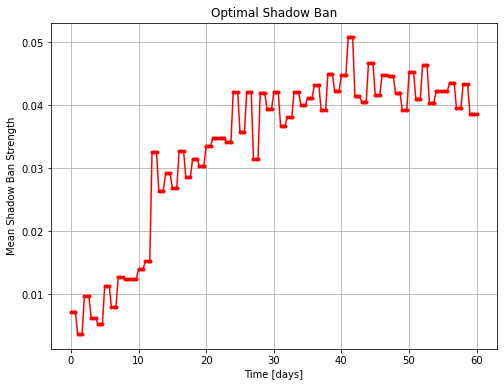

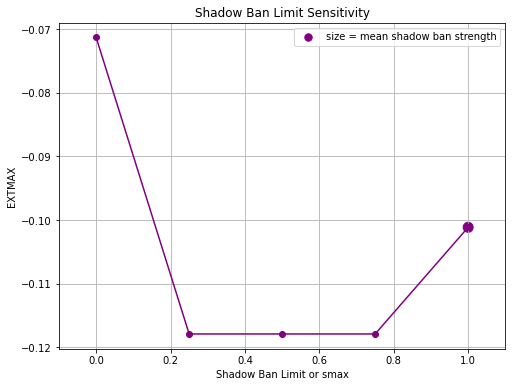

Memory usage: 5225.14432 mega bytes
CPU usage: 16.3 %
CPU times: user 57min 53s, sys: 14min 46s, total: 1h 12min 39s
Wall time: 1h 17min 1s


In [19]:
%%time

import cProfile
# Create a profiler object
profiler = cProfile.Profile()

# Start profiling
profiler.enable()



# no ban
start_time = time.time()
env_no_ban = OpinionSimulatorContinuous(params, False)
Opinions_no_ban, Controls_no_ban = opinion_simulation_list(env_no_ban)
print(f"Took {(time.time()-start_time)/60:.2f} mins to simulate no ban")

T = np.linspace(0, Tf, sim_steps*control_steps + 1) # for plots

# for OBJECTIVE in ['MEAN']:
# for OBJECTIVE in ['VARMAX']:
# for OBJECTIVE in ['VARMIN']:
for OBJECTIVE in ['EXTMAX']:
    params['OBJECTIVE'] = OBJECTIVE
    
    # objective of no ban
    obj_no_ban = cost_sim(OBJECTIVE, Opinions_no_ban, Controls_no_ban, thres=params['thres'])

    # plot no ban
    plt.figure(figsize = (8,6))
    plot_opinion_quantiles(T, Opinions_no_ban, U=Controls_no_ban)
    # plot_opinions(T, Opinions_no_ban)
    plt.ylim(-0.1, 1.1)
    plt.title(f"No Shadow Ban {OBJECTIVE} = {obj_no_ban:.4f}")
    plt.savefig(f"results/{params['data_name']}/No Shadow Ban {OBJECTIVE}.jpg", format="jpg")
    
    # save no ban
    np.savez(f"results/{params['data_name']}/No Shadow Ban {OBJECTIVE}.npz", 
             OBJECTIVE=params['OBJECTIVE'], tau=tau, omega=omega, Tf=Tf, T=T, obj=obj_no_ban, Opinions=Opinions_no_ban)
        
    # smax sensitivity
    smax_range = np.arange(0.0, 1.1, 0.25)
    objs_ban = []
    means_ban = [] # bubble size
    for smax in smax_range:
        params['smax'] = smax

        # shadow ban
        start_time = time.time()
        env_ban = OpinionSimulatorContinuous(params, True)
        Opinions_ban, Controls_ban = opinion_simulation_list(env_ban)
        obj_ban = cost_sim(OBJECTIVE, Opinions_ban, Controls_ban, thres=params['thres'])

        print(f"Took {(time.time()-start_time)/60:.2f} mins to simulate ban {OBJECTIVE} smax = {smax}")

        mean_control = np.mean(Controls_ban)
        
        objs_ban.append(obj_ban)
        means_ban.append(1-mean_control)
        
        # plot smax == 0.5
        if smax == 0.5:
            plt.figure(figsize = (8,6))
            plot_opinion_quantiles(T, Opinions_ban, U=Controls_ban)
            # plot_opinions(T, Opinions_ban)
            plt.ylim(-0.1, 1.1)
            plt.title(f"Shadow Ban {OBJECTIVE} = {obj_ban:.4f}")
            plt.savefig(f"results/{params['data_name']}/Shadow Ban {OBJECTIVE}.jpg", format="jpg")            

            # density distribution shift
            plt.figure(figsize = (8,6))
            plot_density(Opinions_ban)
            plt.xlabel('Opinion')
            plt.ylabel('Kernel Density')
            plt.title('Opinion Density Distribution')
            plt.savefig(f"results/{params['data_name']}/Opinion Density {OBJECTIVE}.jpg", format="jpg")            
            
            # mean ban vs. time
            plt.figure(figsize = (8,6))
            mean_control_time = np.mean(Controls_ban, axis=1)
            T_plot = np.linspace(0,Tf,mean_control_time.shape[0])
            plt.plot(T_plot, 1-mean_control_time, '.-', color = 'red', label='Mean Shadow Ban')
            plt.grid()
            plt.xlabel("Time [days]")
            plt.ylabel("Mean Shadow Ban Strength")
            plt.title(f"Optimal Shadow Ban")
            plt.savefig(f"results/{params['data_name']}/Optimal Shadow Ban {OBJECTIVE}.jpg", format="jpg")
            
        # save shadow ban
        np.savez(f"results/{params['data_name']}/Shadow Ban {params['OBJECTIVE']}_smax={params['smax']}.npz", 
                 OBJECTIVE=params['OBJECTIVE'], tau=tau, omega=omega, Tf=Tf, T=T, obj=obj_no_ban, Opinions=Opinions_no_ban)
            
    # plot smax sensitivity
    plt.figure(figsize = (8,6))
    plot_smax_sens(smax_range, objs_ban, means_ban)
    plt.xlabel("Shadow Ban Limit or smax")
    plt.ylabel(f"{OBJECTIVE}")
    plt.title(f"Shadow Ban Limit Sensitivity")
    plt.savefig(f"results/{params['data_name']}/Shadow Ban Limit Sensitivity {OBJECTIVE}.jpg", format="jpg")            
    
    plt.show()
    
    
# Get memory usage
memory = psutil.virtual_memory()
print("Memory usage:", memory.used/10**6, "mega bytes")

# Get CPU usage
cpu_percent = psutil.cpu_percent(interval=10)
print("CPU usage:", cpu_percent, "%")


# Stop profiling
profiler.disable()

# Save the results to a file
profiler.dump_stats('profile_results.txt')

In [20]:
import pstats

# Load the profiling results from the file
stats = pstats.Stats('profile_results.txt')

# Print the profiling results, sorted
stats.sort_stats(pstats.SortKey.TIME)
stats.print_stats()

Sat Jun 24 23:12:54 2023    profile_results.txt

         7692934 function calls (7642288 primitive calls) in 4619.904 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      300 1415.012    4.717 1415.012    4.717 {scipy.optimize._highs.cython.src._highs_wrapper._highs_wrapper}
     8640  997.468    0.115  997.468    0.115 {built-in method scipy.sparse._sparsetools.csr_sort_indices}
     4620  493.265    0.107  544.094    0.118 <ipython-input-18-c1ad20d70703>:6(shift)
    13260  283.247    0.021  283.247    0.021 {built-in method scipy.sparse._sparsetools.coo_tocsr}
     4320  214.137    0.050 2586.558    0.599 /Users/ys/Documents/GitHub/opinion_dynamics/scripts/dynamics_simulator.py:123(sim_slope)
    61066  156.018    0.003  156.024    0.003 {method 'reduce' of 'numpy.ufunc' objects}
     4320  153.242    0.035  153.242    0.035 {built-in method scipy.sparse._sparsetools.csr_elmul_csr}
   122670  153.170    0.001  153.170 

In [ ]:
data = np.load('results/US Election/No Shadow Ban VARMIN.npz')

In [ ]:
data['obj']